<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import kagglehub

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [110]:
image_size = 64
batch_size = 64
stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [111]:
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/faces-dataset-small


In [112]:
def get_dataloader(path_data, image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """

  train_ds = ImageFolder(path_data, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

  Train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers =2, pin_memory=True)

  sample_image, _ = train_ds[0]
  print(f"Размер одного изображения: {sample_image.shape}")
  return Train_dl

In [113]:
Train_Data_Loader = get_dataloader(path, image_size, batch_size=batch_size, stats=stats)

Размер одного изображения: torch.Size([3, 64, 64])


In [114]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [115]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

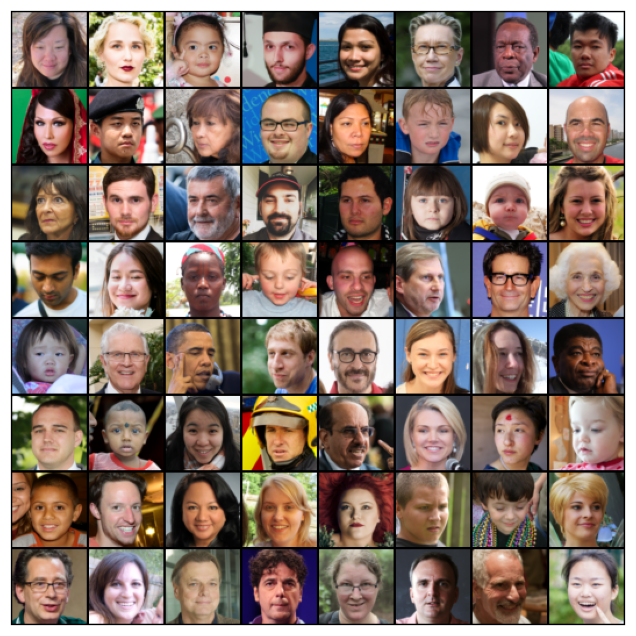

In [116]:
show_batch(Train_Data_Loader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [117]:
discriminator = nn.Sequential(
    # Input: (batch_size, 3, 64, 64)
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64 -> 32x32
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 16x16
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 8x8
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 4x4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [130]:
generator = nn.Sequential(
    # Input: [batch, 128, 1, 1]
    nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),  # 1x1 -> 4x4
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 16x16 -> 32x32
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 32x32 -> 64x64
    nn.Tanh()
)

torch.Size([64, 3, 64, 64])


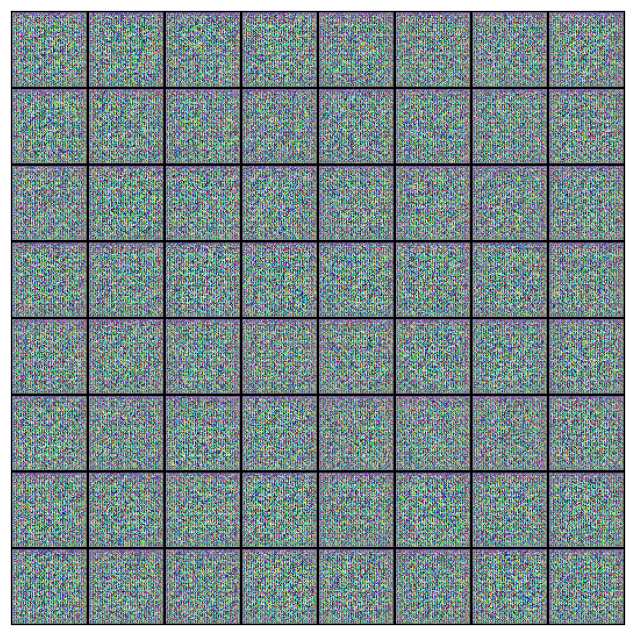

In [131]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:

> Добавить блок с цитатой


  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [132]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [133]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [134]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(path, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [135]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model['discriminator'].train()
    model['generator'].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr, betas=(0.5, 0.999)),
    }

    for epoch in range(epochs):  # Fixed: Use `epoch` instead of `epochs`
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in Train_Data_Loader:
            # --- Discriminator Training ---
            optimizer["discriminator"].zero_grad()

            # Real images
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)  # Вместо [batch, 1]
            real_loss = criterion['discriminator'](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)
            fake_preds = model['discriminator'](fake_images.detach())  # Detach to avoid generator gradient update
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            # Update discriminator
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()  # Fixed: Typo corrected

            # --- Generator Training ---
            optimizer['generator'].zero_grad()
            fake_preds = model['discriminator'](fake_images)  # Re-forward pass (no detach)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion['generator'](fake_preds, targets)
            loss_g.backward()
            optimizer['generator'].step()

            # Store batch results
            loss_d_per_epoch.append(loss_d.item())
            loss_g_per_epoch.append(loss_g.item())
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

        # Store epoch averages
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"loss_g: {losses_g[-1]:.4f}, "
              f"loss_d: {losses_d[-1]:.4f}, "
              f"real_score: {real_scores[-1]:.4f}, "
              f"fake_score: {fake_scores[-1]:.4f}")

        # Save generated images at the last epoch
        if epoch == epochs - 1:  # Fixed: Compare `epoch` (loop var) with `epochs` (total)
            save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [136]:
lr = 0.0002
epoch = 40
history = fit(model, criterion, epochs=epoch, lr=lr)

Epoch [1/40], loss_g: 9.7792, loss_d: 0.5005, real_score: 0.8776, fake_score: 0.1713
Epoch [2/40], loss_g: 9.6455, loss_d: 0.2133, real_score: 0.9229, fake_score: 0.0883
Epoch [3/40], loss_g: 8.6412, loss_d: 0.1577, real_score: 0.9454, fake_score: 0.0640
Epoch [4/40], loss_g: 8.3941, loss_d: 0.3904, real_score: 0.8969, fake_score: 0.0905
Epoch [5/40], loss_g: 4.9501, loss_d: 0.5752, real_score: 0.8086, fake_score: 0.1673
Epoch [6/40], loss_g: 5.1461, loss_d: 0.5455, real_score: 0.8217, fake_score: 0.1692
Epoch [7/40], loss_g: 4.4366, loss_d: 0.4675, real_score: 0.8345, fake_score: 0.1621
Epoch [8/40], loss_g: 4.6713, loss_d: 0.5249, real_score: 0.8259, fake_score: 0.1663
Epoch [9/40], loss_g: 5.3597, loss_d: 0.4562, real_score: 0.8562, fake_score: 0.1506
Epoch [10/40], loss_g: 5.8170, loss_d: 0.4306, real_score: 0.8583, fake_score: 0.1364
Epoch [11/40], loss_g: 4.7379, loss_d: 0.6406, real_score: 0.7995, fake_score: 0.1986
Epoch [12/40], loss_g: 4.3738, loss_d: 0.5216, real_score: 0.81

KeyboardInterrupt: 

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [140]:
def evaluate_generator(generator, latent_size, device, num_images=16, figsize=(12, 12),
                      nrow=4, return_images=False, show=True):
    """
    Оценивает качество сгенерированных изображений

    Args:
        generator (nn.Module): Обученный генератор
        latent_size (int): Размер латентного пространства
        device (torch.device): Устройство (cpu/cuda)
        num_images (int): Количество изображений для генерации
        figsize (tuple): Размер фигуры matplotlib
        nrow (int): Количество изображений в строке
        return_images (bool): Возвращать ли тензор с изображениями
        show (bool): Показывать ли изображения

    Returns:
        (optional) torch.Tensor: Сгенерированные изображения (если return_images=True)
    """
    # Переводим генератор в режим оценки
    generator.eval()

    # Генерируем случайные векторы
    noise = torch.randn(num_images, latent_size, 1, 1).to(device)

    # Генерируем изображения без вычисления градиентов
    with torch.no_grad():
        generated_images = generator(noise)

    # Денормализуем изображения
    generated_images = denorm(generated_images)

    if show:
        # Создаем сетку изображений
        grid = make_grid(generated_images, nrow=nrow, padding=2, pad_value=1)

        # Подготавливаем для отображения
        plt.figure(figsize=figsize)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(f"Сгенерированные изображения (n={num_images})")
        plt.show()

    if return_images:
        return generated_images

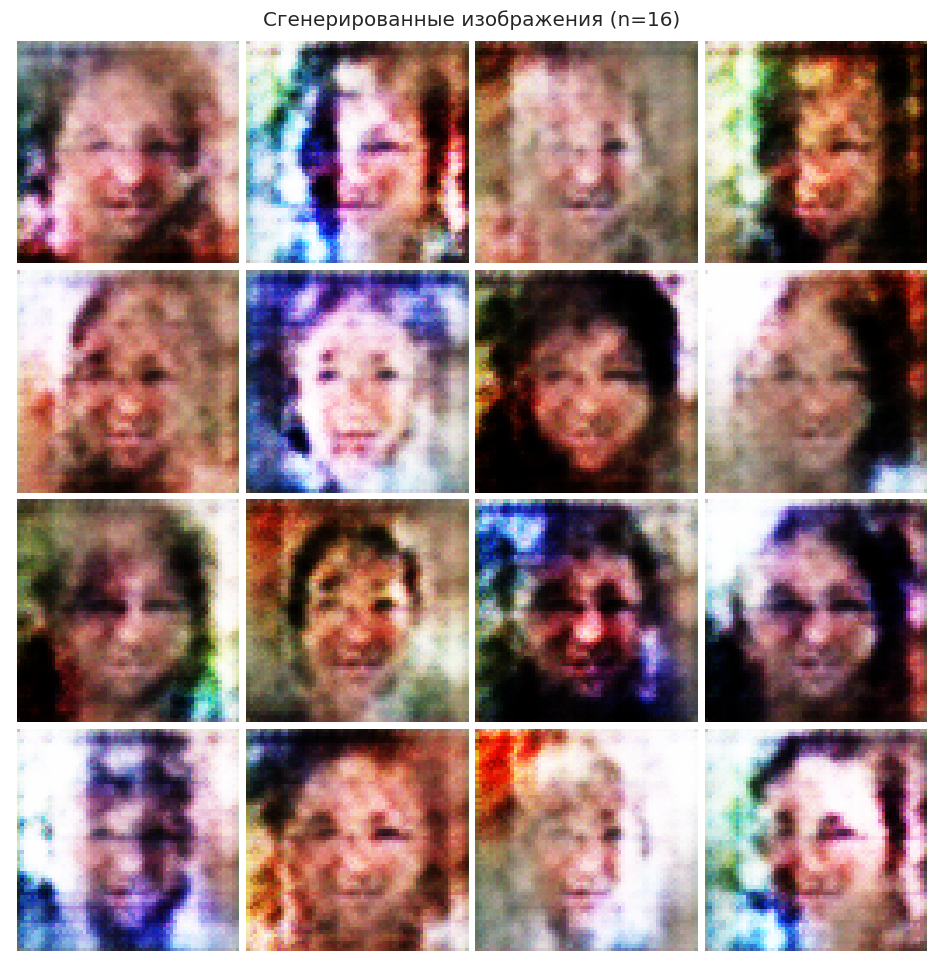

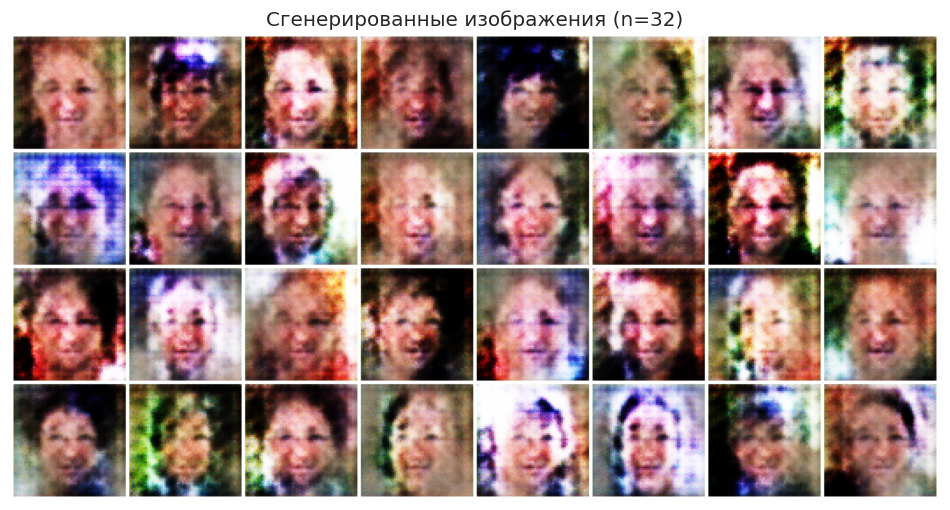

In [141]:
# Оцениваем генератор и показываем 16 изображений
evaluate_generator(generator, latent_size, device)

# Оцениваем и сохраняем изображения для дальнейшего анализа
generated = evaluate_generator(generator, latent_size, device,
                             num_images=32, nrow=8, return_images=True)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: